In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [47]:
ALL_METHODS = ['BEST', 'FREE', 'LPMS', 'Trigram', 'VGGraph']

In [2]:
FIG_PREFIX = 'revision2/dblp1000'

In [3]:
rev_dir = '../result/revision/dblp'
rev_dir2 = '../result/revision/dblp2'

In [4]:
trigram_dir = '../result/trigram_result/result/dblp_small_1000_trigram_result'
vggraph_dir = '../result/vggraph_result/dblp_small_1000_vggraph_greedy_revision'

In [5]:
root_dir = '../result/dblp_small_1000_result'
root_best_dir = '../result/dblp_small_1000_best_red_result'
root_lpms_dir = '../result/dblp_small_1000_lpms_result'
root_free_dir = '../result/dblp_small_1000_free_result2S'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [6]:
def build_stats_filename(row, reduced, revision=False):
    name = row['name']
    if 'parallel' in name:
        name = name.split('-')[0]
    if 'VGGraph-Greedy' in name:
        name = 'VGGRAPH'
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if 'Trigram' in name:
        fields[2] = '-1'
    if reduced is not None:
        fields.insert(-1, str(reduced))
    elif revision and 'BEST' in name:
        fields.insert(-1, '-1')
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{int(row['num_threads'])}"
        space_file += '_determ' if 'DETER' in name else '_random'
    else:
        if 'VGGraph-Greedy' in row['name']:
            space_file += f"{row['name'].lower().replace('-', '_')}_t{int(row['num_threads'])}"
        else:
            space_file += f"{name.lower()}_t{int(row['num_threads'])}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        if 'Trigram' not in name:
            space_file += f"_c{row['selectivity']}"
        if 'FREE' in name or 'VG' in name:
            space_file += f"_n{row['gram_size']}"
    # max_num = -1
    if 'key_upper_bound' in row:
        space_file += f"_{int(row['key_upper_bound'])}"
        fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [7]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [8]:
def get_stats_df(row, reduced=None, root_dir=root_dir, revision=False):
    fname, space_f = build_stats_filename(row, reduced, revision)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [9]:
def add_num_after_filter(df, reduced_list=None, root_dir=root_dir, revision=False):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, reduced=reduced, root_dir=root_dir, revision=revision)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [10]:
def build_result_df(root_dir, reduced, revision=False):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    res_df = add_num_after_filter(res_df, reduced_list=reduced, root_dir=root_dir, revision=revision)
    return res_df

In [11]:
res_dfrev = build_result_df(rev_dir, reduced=None, revision=True)

In [12]:
res_dfrev2 = build_result_df(rev_dir2, reduced=None, revision=True)

In [13]:
res_trigram = build_result_df(trigram_dir, reduced=None, revision=True)

In [68]:
res_trigram

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
0,Trigram,16.0,3.0,-1.0,200.0,200.0,1000.0,0.001772,0.126449,0.128221,7908624.0,0.006414,71.118791,71.125205,71.253426,199039991,199039.991,920934,165776
1,Trigram,16.0,3.0,-1.0,500.0,500.0,1000.0,0.001906,0.190963,0.192870,14152840.0,0.006336,53.970154,53.976490,54.169360,142443517,142443.517,918461,208040
2,Trigram,16.0,3.0,-1.0,1000.0,1000.0,1000.0,0.002420,0.277060,0.279480,20405432.0,0.006430,40.826637,40.833067,41.112547,102319601,102319.601,916393,194176
3,Trigram,16.0,3.0,-1.0,2000.0,2000.0,1000.0,0.003791,0.398972,0.402763,31874328.0,0.006364,27.187184,27.193548,27.596311,54322980,54322.980,917705,277228
4,Trigram,16.0,3.0,-1.0,28275.0,-1.0,1000.0,0.315072,1.452510,1.767580,88614162.0,0.005723,14.122280,14.128003,15.895583,946301,946.301,917909,1039504


In [14]:
res_vggraph = build_result_df(vggraph_dir, reduced=None, revision=True)

In [15]:
res_df1 = build_result_df(root_dir, None)

In [16]:
res_lpms_df = build_result_df(root_lpms_dir, None)

Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_20.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_50.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_100.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_150.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_200.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_500.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_1000.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_20.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_50.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_100.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms

In [17]:
res_free_df = build_result_df(root_free_dir, None)

In [18]:
res_best_df = build_result_df(root_best_dir, [50]*7 + [100]*7 + [200]*7 + [300]*3 + [500]*2 + [700]*2 + [850]*2)

In [19]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [31]:
res_df = pd.concat([res_trigram, res_vggraph, res_dfrev, res_dfrev2, res_df1, res_best_df, res_lpms_df, res_free_df], ignore_index=True)

In [32]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['method', 'gram_size'])

In [34]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
105,VGGraph-Greedy,16.0,6.0,0.12,4747.0,-1.0,1000.0,3.700000e-07,5.29787,5.29787,...,14.048217,14.05418,19.35205,1340018,1340.018,913841,323712,0.318038,0.681962,VGGraph


In [67]:
res_df[res_df.name == 'Trigram']

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision,method
0,Trigram,16.0,3.0,-1.0,200.0,200.0,1000.0,0.001772,0.126449,0.128221,...,71.118791,71.125205,71.253426,199039991,199039.991,920934,165776,0.995373,0.004627,Trigram
1,Trigram,16.0,3.0,-1.0,500.0,500.0,1000.0,0.001906,0.190963,0.192870,...,53.970154,53.976490,54.169360,142443517,142443.517,918461,208040,0.993552,0.006448,Trigram
2,Trigram,16.0,3.0,-1.0,1000.0,1000.0,1000.0,0.002420,0.277060,0.279480,...,40.826637,40.833067,41.112547,102319601,102319.601,916393,194176,0.991044,0.008956,Trigram
3,Trigram,16.0,3.0,-1.0,2000.0,2000.0,1000.0,0.003791,0.398972,0.402763,...,27.187184,27.193548,27.596311,54322980,54322.980,917705,277228,0.983107,0.016893,Trigram
4,Trigram,16.0,3.0,-1.0,28275.0,-1.0,1000.0,0.315072,1.452510,1.767580,...,14.122280,14.128003,15.895583,946301,946.301,917909,1039504,0.030003,0.969997,Trigram


In [37]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms ',
    'Trig' : '\\trigram ',
    'VGGr': '\\vgg '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None

for up_lim in [150, 500, 1000, 2000, 3000, 4000, 5000]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    # curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(up_lim)+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.3f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\")
        else:
            print("\\\\ \midrule")

\multirow{3}{*}{\bf{150}}& \best  & \cellcolor{green!50}{19.7} & 533 & 2.194 & \cellcolor{green!50}{33.433} & \cellcolor{yellow!50}{0.235} \\
& \free  & 20.5 & \cellcolor{green!50}{1} & 0.170 & 37.299 & 0.052 \\
& \lpms  & 19.8 & 3 & \cellcolor{green!50}{-0.000} & 34.028 & 0.048 \\ \midrule
\multirow{5}{*}{\bf{500}}& \best  & \cellcolor{green!50}{15.2} & 8762 & 2.670 & 54.306 & \cellcolor{yellow!50}{0.242} \\
& \free  & 16.5 & 1 & 0.241 & 66.774 & 0.174 \\
& \lpms  & 17.7 & 6 & \cellcolor{green!50}{-0.000} & 40.657 & 0.070 \\
& \trigram  & 54.0 & \cellcolor{green!50}{0} & 0.208 & \cellcolor{green!50}{14.153} & 0.006 \\
& \vgg  & 22.1 & 0 & 0.276 & 14.198 & 0.035 \\ \midrule
\multirow{5}{*}{\bf{1000}}& \best  & \cellcolor{green!50}{15.2} & 8762 & 2.670 & 54.306 & \cellcolor{yellow!50}{0.242} \\
& \free  & 15.9 & 2 & 0.261 & 75.354 & 0.234 \\
& \lpms  & 17.0 & 808 & 1.309 & 41.499 & 0.071 \\
& \trigram  & 40.8 & \cellcolor{green!50}{0} & \cellcolor{green!50}{0.194} & \cellcolor{green!50}

In [58]:
overall_df = None
df_by_lims = {}
lims = [150, 500, 1000, 2000, 3000, 4000,]
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ALL_METHODS:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
    df_by_lims[up_lim] = curr_group
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

In [59]:
overall_df

,name,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,...,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,prop_error,precision
0,BEST,16.0,-1.0,0.50,150.0,150.0,1000.0,5.325460e+02,0.011743,532.558000,...,0.006376,19.663383,19.669759,552.227759,3894299.0,3894.299,913841.0,2193748,0.765339,0.234661
1,FREE,16.0,2.0,0.70,150.0,150.0,0.0,1.137230e+00,0.131861,1.269100,...,0.006463,20.463992,20.470455,21.739555,17638837.0,17638.837,913841.0,170324,0.948192,0.051808
2,LPMS,16.0,-1.0,-1.00,150.0,150.0,1000.0,2.701140e+00,-1.000000,2.701140,...,0.005768,19.773800,19.779568,22.480708,18920200.0,18920.200,913841.0,-1,0.951700,0.048300
3,Trigram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
4,VGGraph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000
5,BEST,16.0,-1.0,0.50,363.0,500.0,1000.0,8.761510e+03,0.023685,8761.530000,...,0.006200,15.151186,15.157386,8776.687386,3780455.0,3780.455,913841.0,2670448,0.758272,0.241728
6,FREE,16.0,2.0,0.70,500.0,500.0,0.0,1.129200e+00,0.184807,1.314000,...,0.006355,16.474061,16.480416,17.794416,5250784.0,5250.784,913841.0,241348,0.825961,0.174039
7,LPMS,16.0,-1.0,-1.00,500.0,500.0,1000.0,6.053920e+00,-1.000000,6.053920,...,0.005817,17.719982,17.725799,23.779719,13076749.0,13076.749,913841.0,-1,0.930117,0.069883
8,Trigram,16.0,3.0,-1.00,500.0,500.0,1000.0,1.906300e-03,0.190963,0.192870,...,0.006336,53.970154,53.976490,54.169360,142443517.0,142443.517,918461.0,208040,0.993552,0.006448
9,VGGraph,16.0,3.0,0.50,215.0,500.0,1000.0,4.710000e-07,0.432494,0.432495,...,0.005812,22.096100,22.101912,22.534407,26382896.0,26382.896,913841.0,275960,0.965362,0.034638


In [60]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

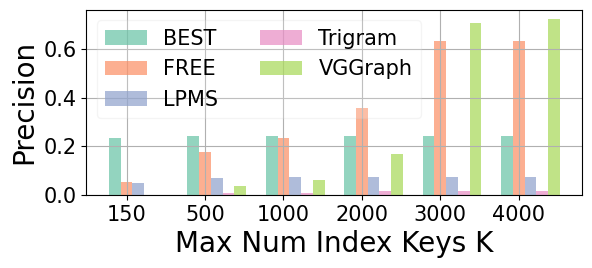

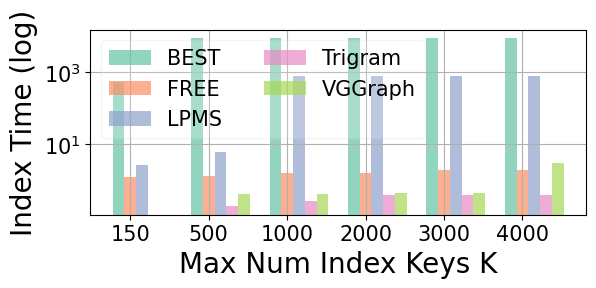

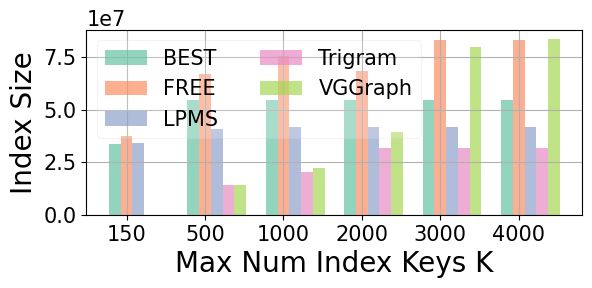

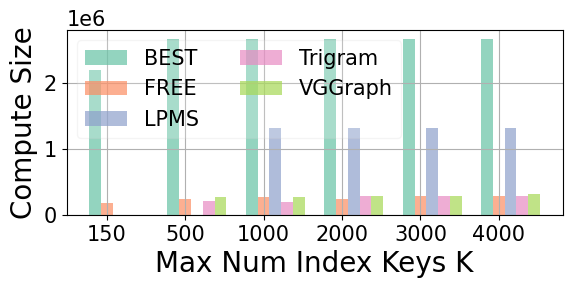

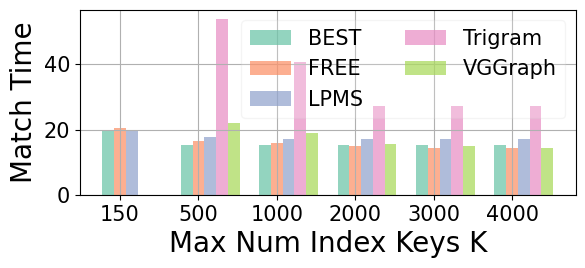

In [65]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size', 'overall_match_time']:
    # fig, ax = plt.subplots(figsize=(10,4.8))
    fig, ax = plt.subplots(figsize=(6.4,2.4))
        
    x = np.arange(len(lims))  # the label locations
    # width = 0.25  # the width of the bars
    width = 0.15
    multiplier = 0
    for method, color in zip(ALL_METHODS, colors):
        curr = overall_df.loc[overall_df["name"] == method]
        
        X = curr['key_upper_bound']
        
        offset = width * multiplier - width
        Y = curr[col].to_numpy()
        rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys K')

    ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])

    # plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
    plt.legend(loc='best', ncol=2, fancybox=True, framealpha=0.2) #, bbox_to_anchor=(0.5, 1.15))
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

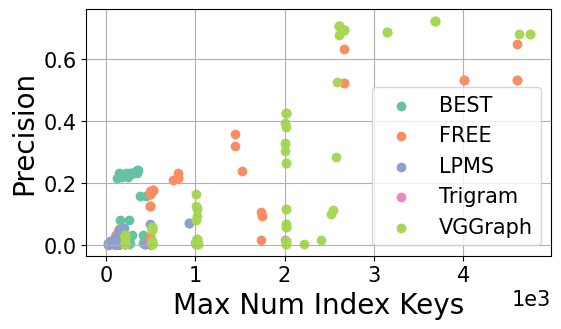

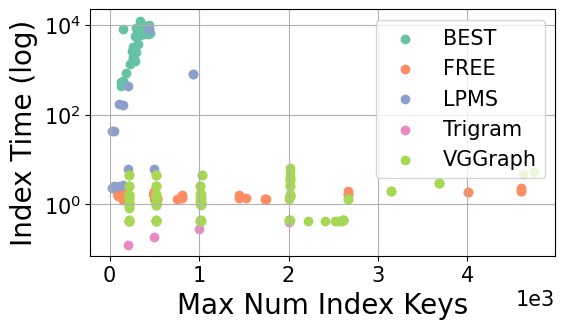

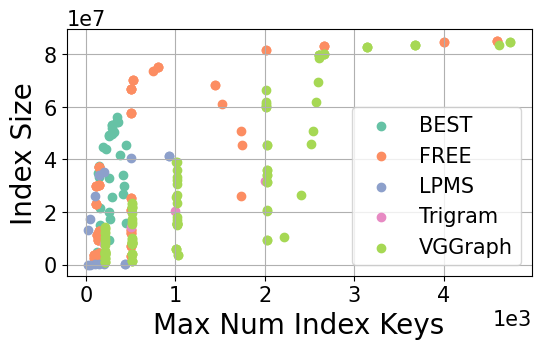

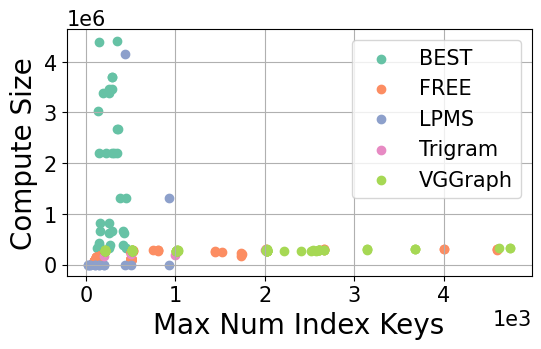

In [57]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    fig, ax = plt.subplots(figsize=(6,3.2))
    
    for method, color in zip(ALL_METHODS, colors):
        curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
        ax.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color, label=method)
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys')

    # ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])
    
    # fig.text(0.5, 0.04, 'Key Upper Bound', ha='center', va='center')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_scatter_{col}.pdf', bbox_inches='tight')
    plt.show()